In [156]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

index = 254460
seed = index
n_samples = 2560


syn1_x, syn1_t = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=seed)
syn1_train_x, syn1_test_x, syn1_train_t, syn1_test_t = train_test_split(syn1_x, syn1_t, test_size=.2, random_state=seed)
min_max_scaler = preprocessing.MinMaxScaler()
syn1_train_x = min_max_scaler.fit_transform(syn1_train_x)
syn1_test_x = min_max_scaler.transform(syn1_test_x)
syn1_test_x_kl1 = syn1_test_x[syn1_test_t == 1]
syn1_test_x_kl2 = syn1_test_x[syn1_test_t == 0]

syn1_data = {
    'train': {
        'x': syn1_train_x,
        't': syn1_train_t
    },
    'test': {
        'x': syn1_test_x,
        't': syn1_test_t
    }
}

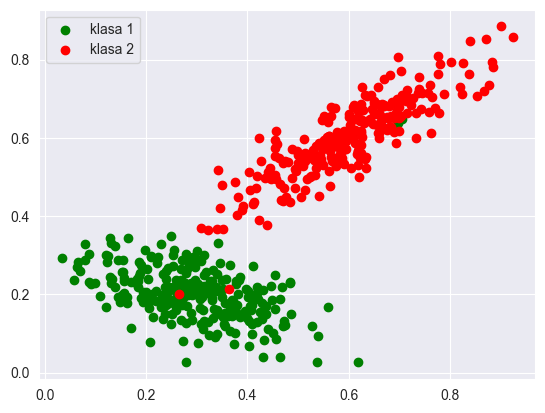

In [157]:
sns.set_style("darkgrid")


plt.scatter(syn1_test_x_kl1[:,0], syn1_test_x_kl1[:,1], c = "g", label="klasa 1")
plt.scatter(syn1_test_x_kl2[:,0], syn1_test_x_kl2[:,1], c = "r", label="klasa 2")
plt.legend()
plt.show()

In [158]:
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression().fit(syn1_data["train"]["x"], syn1_data["train"]["t"])
clf.score(syn1_data["test"]["x"], syn1_data["test"]["t"])

0.984375

In [238]:
from sklearn.preprocessing import PolynomialFeatures
import statistics


class CustomLogisticRegression:
    def __init__(self, epoch_nb, threshold, step) -> None:
        self.BETA = 1
        self.STEP = step
        self.THRESHOLD = threshold
        self.X = None
        self.targets = None
        self.epoch_nb = epoch_nb
        self.teta = None
        self.cus_prob = None

    def F(self, S):
        #print(S)
        if S > 500:
            S = 500
        elif S < -500:
            S = -500
        res = np.array(1/(1+np.exp(-self.BETA*S)))
        return res
    
    def fit(self, train_data, targets):
        self.X = train_data
        self.teta = np.random.rand(train_data.shape[1],)
        self.targets = targets
        self.cus_prob = np.zeros_like(targets)
        for _ in range(self.epoch_nb):
            for i in range(self.X.shape[0]):
                self.teta = self.teta + (self.STEP*(self.targets[i] - self.F(self.teta.T@self.X[i])))*self.X[i]
            E = [self.targets[i] - self.F(self.teta.T@self.X[i]) for i in range(self.X.shape[0])]
            if statistics.mean(E) < self.THRESHOLD:
                break

    def predict(self, test_data):
        self.cus_prob = test_data@self.teta
        res = np.array([1 if score >= 0 else 0 for score in self.cus_prob])
        return res
    
    def score(self, predicted_val, true_val):
        j = 0
        for i, val in enumerate(true_val):
            if val == predicted_val[i]:
                j+=1
        score = j/len(predicted_val)
        return score


In [ ]:


X = syn1_data["train"]["x"]
X = np.hstack([np.ones((X.shape[0], 1)), X])
logistic_regresion = CustomLogisticRegression(X, syn1_data["train"]["t"], 100, 0.01, 0.01)
#print(syn1_data["train"]["t"])
logistic_regresion.fit()
xx, yy = np.meshgrid(np.arange(0, 1, 0.001),
                     np.arange(0, 1, 0.001))
poly = PolynomialFeatures(degree=1, include_bias=True)
Z = poly.fit_transform(np.c_[xx.ravel(), yy.ravel()])
Z = logistic_regresion.predict(Z)
Z = Z.reshape(xx.shape)
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
ax = axs[0]
ax.scatter(syn1_test_x_kl1[:,0], syn1_test_x_kl1[:,1], c = "g", label="klasa 1")
ax.scatter(syn1_test_x_kl2[:,0], syn1_test_x_kl2[:,1], c = "r", label="klasa 2")
ax.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
ax.set_title("Metoda custom")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()
ax = axs[1]
Z = np.c_[xx.ravel(), yy.ravel()]
Z = clf.predict(Z)
Z = Z.reshape(xx.shape)
ax.scatter(syn1_test_x_kl1[:,0], syn1_test_x_kl1[:,1], c = "g", label="klasa 1")
ax.scatter(syn1_test_x_kl2[:,0], syn1_test_x_kl2[:,1], c = "r", label="klasa 2")
ax.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
ax.set_title("Metoda sklearn")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()
fig.tight_layout()

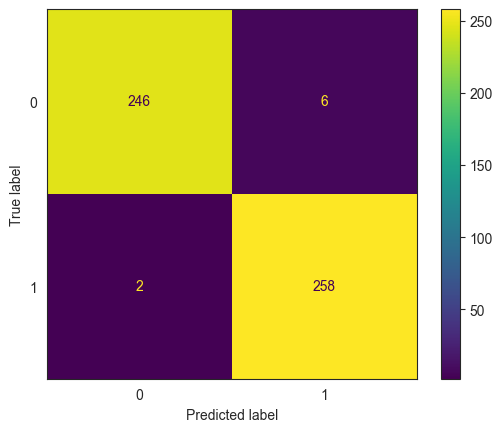

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


skl_y = clf.predict(syn1_data["test"]["x"])
sns.set_style("white")
cm_S = confusion_matrix(syn1_data["test"]["t"], skl_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

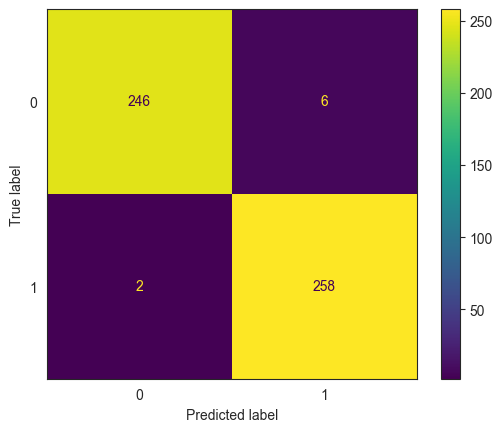

In [ ]:
X = syn1_data["test"]["x"]
X = np.hstack([np.ones((X.shape[0], 1)), X])
cus_y = logistic_regresion.predict(X)
cm_S = confusion_matrix(syn1_data["test"]["t"], cus_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

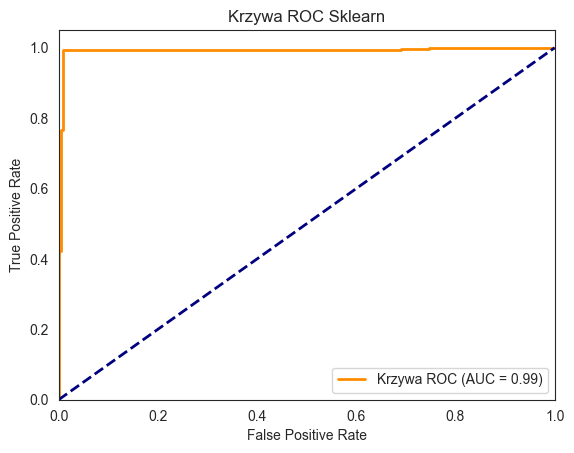

In [ ]:
from sklearn.metrics import roc_curve, auc

skl_prob = clf.decision_function(syn1_data["test"]["x"])
fpr, tpr, thresholds = roc_curve(syn1_data["test"]["t"], skl_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()

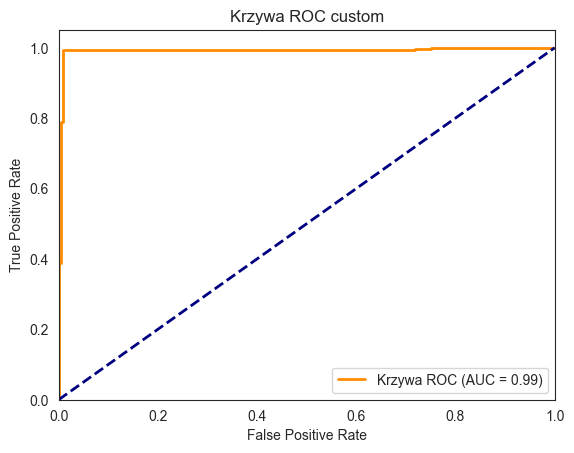

In [ ]:
cus_prob = logistic_regresion.cus_prob
fpr, tpr, thresholds = roc_curve(syn1_data["test"]["t"], cus_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC custom')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.datasets import make_moons


syn2_x, syn2_y = make_moons(n_samples=n_samples, random_state=seed, noise=0.1)
syn2_train_x, syn2_test_x, syn2_train_t, syn2_test_t = train_test_split(syn2_x, syn2_y, test_size=.2, random_state=seed)
# syn2_train_x = min_max_scaler.fit_transform(syn2_train_x)
# syn2_test_x = min_max_scaler.transform(syn2_test_x)
syn2_test_x_kl1 = syn2_test_x[syn2_test_t == 0]
syn2_test_x_kl2 = syn2_test_x[syn2_test_t == 1]

syn2_data = {
    "train": 
    {
        "x" : syn2_train_x,
        "t" : syn2_train_t
    },
    "test":
    {
        "x" : syn2_test_x,
        "t" : syn2_test_t
    }
}

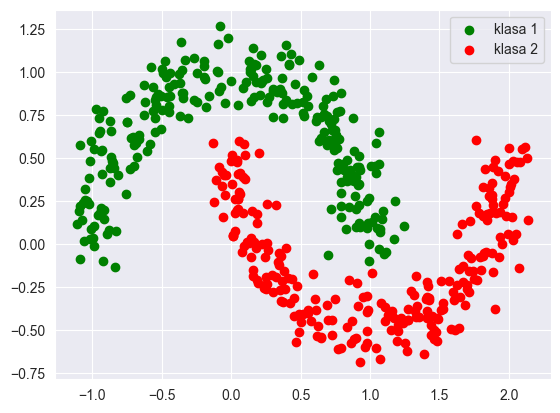

In [ ]:
sns.set_style("darkgrid")


plt.scatter(syn2_test_x_kl1[:,0], syn2_test_x_kl1[:,1], c = "g", label="klasa 1")
plt.scatter(syn2_test_x_kl2[:,0], syn2_test_x_kl2[:,1], c = "r", label="klasa 2")
plt.legend()
plt.show()

In [ ]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_pol = poly.fit_transform(syn2_data["train"]["x"])
X_test_pol = poly.fit_transform(syn2_data["test"]["x"])
clf = LogisticRegression().fit(X_train_pol, syn2_data["train"]["t"])
clf.score(X_test_pol, syn2_data["test"]["t"])

0.98828125

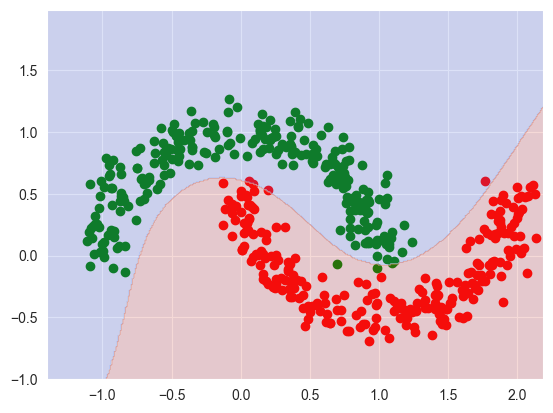

In [ ]:
xx, yy = np.meshgrid(np.arange(-1.4, 2.2, 0.01),
                     np.arange(-1, 2, 0.01))
Z = poly.fit_transform(np.c_[xx.ravel(), yy.ravel()])
Z = clf.predict(Z)
Z = Z.reshape(xx.shape)
plt.scatter(syn2_test_x_kl1[:,0], syn2_test_x_kl1[:,1], c = "g", label="klasa 1")
plt.scatter(syn2_test_x_kl2[:,0], syn2_test_x_kl2[:,1], c = "r", label="klasa 2")
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)

In [ ]:
poly = PolynomialFeatures(degree=3, include_bias=True)
X = syn2_data["train"]["x"]
X_train_pol = poly.fit_transform(X)
logistic_regresion = CustomLogisticRegression(X_train_pol, syn2_data["train"]["t"], 100, 0.001, 0.01)
logistic_regresion.fit()
X = syn2_data["test"]["x"]
X_test_pol = poly.fit_transform(X)

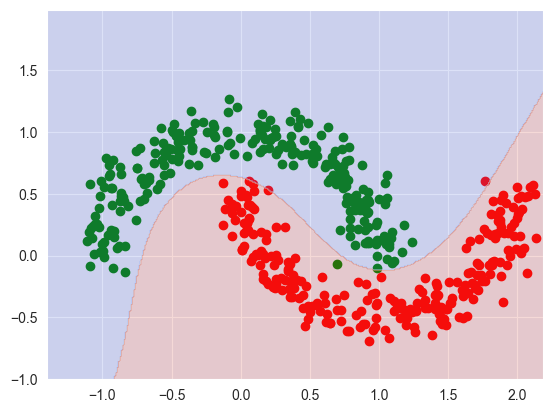

In [ ]:
xx, yy = np.meshgrid(np.arange(-1.4, 2.2, 0.01),
                     np.arange(-1, 2, 0.01))
Z = poly.fit_transform(np.c_[xx.ravel(), yy.ravel()])
Z = logistic_regresion.predict(Z)
Z = Z.reshape(xx.shape)
plt.scatter(syn2_test_x_kl1[:,0], syn2_test_x_kl1[:,1], c = "g", label="klasa 1")
plt.scatter(syn2_test_x_kl2[:,0], syn2_test_x_kl2[:,1], c = "r", label="klasa 2")
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)

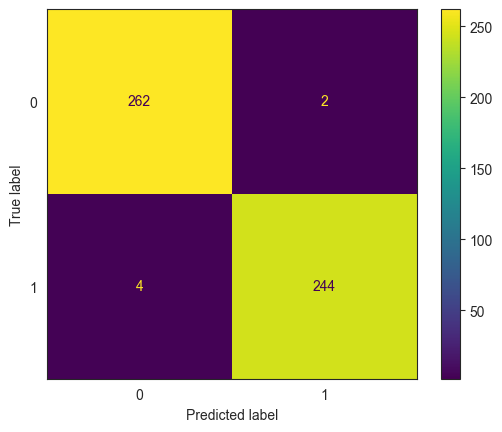

In [ ]:
sns.set_style("white")


poly = PolynomialFeatures(degree=3, include_bias=False)
X = syn2_data["test"]["x"]
X_train_pol = poly.fit_transform(X)
skl_y = clf.predict(X_train_pol)
cm_S = confusion_matrix(syn2_data["test"]["t"], skl_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

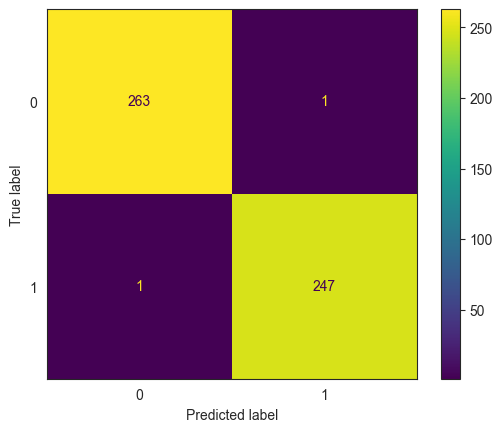

In [ ]:
sns.set_style("white")


poly = PolynomialFeatures(degree=3, include_bias=True)
X = syn2_data["test"]["x"]
X_train_pol = poly.fit_transform(X)
cm_y = logistic_regresion.predict(X_train_pol)
cm_S = confusion_matrix(syn2_data["test"]["t"], cm_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

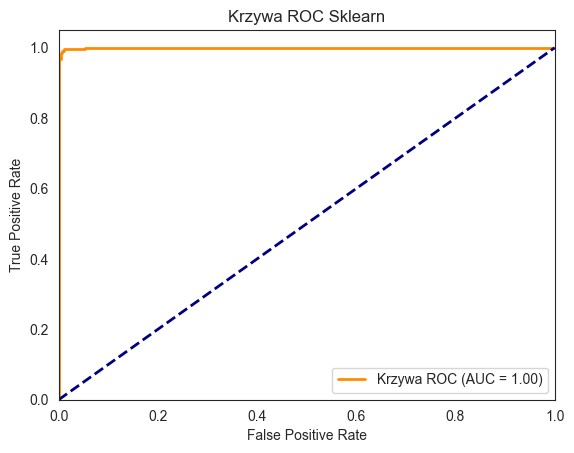

In [ ]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X = syn2_data["test"]["x"]
X_train_pol = poly.fit_transform(X)

skl_prob = clf.decision_function(X_train_pol)
fpr, tpr, thresholds = roc_curve(syn2_data["test"]["t"], skl_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()

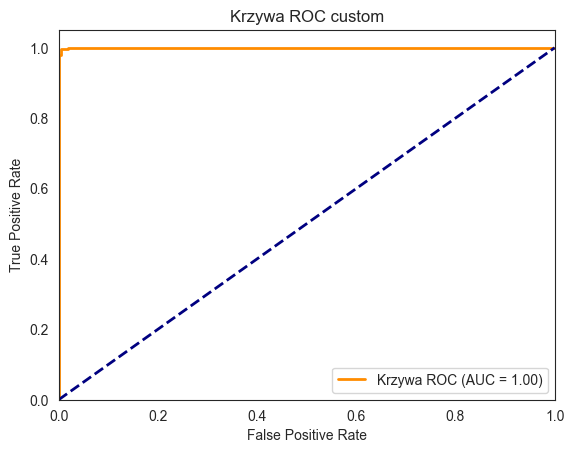

In [ ]:
cus_prob = logistic_regresion.cus_prob
fpr, tpr, thresholds = roc_curve(syn2_data["test"]["t"], cus_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC custom')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pandas as pd


#import danych formatu CSV
with open("rainAUS.csv", "rb") as f:
    rain_data_df = pd.read_csv(f)

#usunięcie kolumn z brakami > 30%
def remove_columns_missing_more_than_30_percent(data):
    missing_percentage = data.isna().mean()*100
    columns_to_drop = missing_percentage[missing_percentage > 30].index
    data = data.drop(columns=columns_to_drop)
    return data

#uzupełnienie danych wartościami dominant oraz median
categorital_values = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
numeric_values = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
def impute_data(categorical_columns_names, numeric_columns_names, data):
    for column in categorical_columns_names:
        dominant_value = data[column].mode()[0]
        data[column] = data[column].fillna(dominant_value)
    for column in numeric_columns_names:
        median_value = data[column].median()
        data[column] = data[column].fillna(median_value)
    return data

#winsoryzacja danych
def winsorization_data(numeric_columns_names, data):
    for column in numeric_columns_names:
        column_data = data[column]
        Q1 = column_data.quantile(0.25)
        Q3 = column_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - IQR
        upper_bound  = Q3 + IQR
        data[column] = data[column].clip(lower=lower_bound, upper=upper_bound)
    return data

#zakodowanie daty        
def transform_data_column(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data.Date.dt.year
    data['DayOfYear'] = data.Date.dt.day_of_year
    data.drop(columns=['Date'], inplace=True)
    return data

def transform_target_value(data):
    data['RainTomorrow'] = [1 if rain == 'Yes' else 0 for rain in data['RainTomorrow']]
    return data

def transform_location(data):
    data['Location'] = pd.factorize(data['Location'])[0]
    return data

def grup_data_by_location(data):
    grouped_data = data.groupby('Location')
    rain_data_locations = {}
    for group_name, group in grouped_data:

        #odseparowanie kolumny RainTomorrow
        rain_tomorrow_df = group.pop('RainTomorrow')
        rain_tomorrow_df = pd.DataFrame(rain_tomorrow_df)
        train_X, test_X, train_t, test_t = train_test_split(group, rain_tomorrow_df, test_size=.2, random_state=seed, stratify=rain_tomorrow_df)
        rain_data_locations[group_name] = {
        'train': {
            'x': train_X,
            't': train_t
        },
        'test': {
            'x': test_X,
            't': test_t
        }
    }
    return rain_data_locations

rain_data_df = remove_columns_missing_more_than_30_percent(rain_data_df)
rain_data_df = impute_data(categorital_values, numeric_values, rain_data_df)
rain_data_df = winsorization_data(numeric_values, rain_data_df)
rain_data_df = transform_data_column(rain_data_df)
rain_data_df = transform_target_value(rain_data_df)
rain_data_df = transform_location(rain_data_df)
rain_data_locations = grup_data_by_location(rain_data_df)
#rain_data_locations[0]['train']['x'].head()


In [201]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline


bin_vars = ['RainToday']
onehot_vars = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
normal_vars = ['Rainfall', 'Year', 'DayOfYear', 'MinTemp', 'MaxTemp', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

dirs = ['N', 'E', 'S', 'W', 'NE', 'SE', 'SW', 'NW', 'NNE', 'ENE', 'ESE', 'SSE', 'SSW', 'WSW', 'WNW', 'NNW']

bin_transform = OrdinalEncoder()
hot_transform = OneHotEncoder(categories=[dirs, dirs, dirs])
std_transform = StandardScaler()
nor_transform = MinMaxScaler()

preprocess_pipeline = ColumnTransformer([
    ('bin', bin_transform, bin_vars),
    ('hot', hot_transform, onehot_vars),
    ('nor', nor_transform, normal_vars),
])

preprocess_pipeline.fit_transform(rain_data_locations[0]['train']['x'])

<2432x63 sparse matrix of type '<class 'numpy.float64'>'
	with 39322 stored elements in Compressed Sparse Row format>

In [221]:
#Wtrenowanie modeli dla każdego obszaru i znalezienie najlepszego wyniku
scikit_model = make_pipeline(
    preprocess_pipeline,
    LogisticRegression(max_iter=1000),
)

scores = []
for i in range(max(rain_data_df['Location'])):
    data_in_location = rain_data_locations[i]
    scikit_model.fit(data_in_location['train']['x'], np.array(data_in_location['train']['t']).reshape(-1))
    scores.append(scikit_model.score(data_in_location['test']['x'], np.array(data_in_location['test']['t']).reshape(-1)))

print(scores.index(max(scores)))

35


In [251]:
custom_model = make_pipeline(
    preprocess_pipeline,
    CustomLogisticRegression(epoch_nb = 10000, threshold=0.0001, step=0.01),
)
data_in_location = rain_data_locations[35]
transformed_data = preprocess_pipeline.transform(data_in_location['train']['x'])
column_names = preprocess_pipeline.get_feature_names_out()
transformed_df = pd.DataFrame(transformed_data.toarray(), columns=column_names)
data_in_loc = np.array(transformed_df)
cum = CustomLogisticRegression(epoch_nb = 100, threshold=0.0000000001, step=0.05)
cum.fit(data_in_loc, np.array(data_in_location['train']['t']).reshape(-1))
transformed_data = preprocess_pipeline.transform(data_in_location['test']['x'])
column_names = preprocess_pipeline.get_feature_names_out()
transformed_df = pd.DataFrame(transformed_data.toarray(), columns=column_names)
data_in_loc = np.array(transformed_df)
pre = cum.predict(transformed_data)
print(cum.score(pre, np.array(data_in_location['test']['t']).reshape(-1)))


0.9435215946843853


In [ ]:
# X = np.array(rain_data_by_locations[best_location]['train']['x'])
# X = np.hstack([np.ones((X.shape[0], 1)), X])
# seta = np.random.rand(X.shape[1],)
# logistic_regresion = CustomLogisticRegression(X, rain_data_by_locations[best_location]['train']['t'], 500, 1e-4, 0.001)
# logistic_regresion.fit()
# X = np.array(rain_data_by_locations[best_location]['test']['x'])
# X = np.hstack([np.ones((X.shape[0], 1)), X])
# predicted = logistic_regresion.predict(X)
# logistic_regresion.score(list(predicted), list(rain_data_by_locations[best_location]['test']['t']))

0.30564784053156147

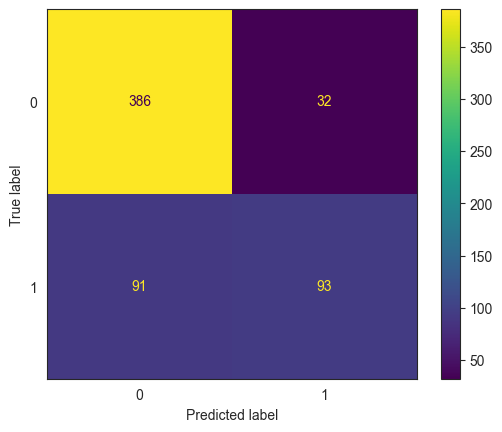

In [ ]:
# clf = LogisticRegression(solver='newton-cg', fit_intercept=True).fit(rain_data_by_locations[best_location]['train']['x'], rain_data_by_locations[best_location]['train']['t'])
# skl_y = clf.predict(rain_data_by_locations[best_location]['test']['x'])
# skl_S = confusion_matrix(rain_data_by_locations[best_location]['test']['t'], skl_y)
# disp = ConfusionMatrixDisplay(confusion_matrix=skl_S)
# disp.plot()
# plt.show()

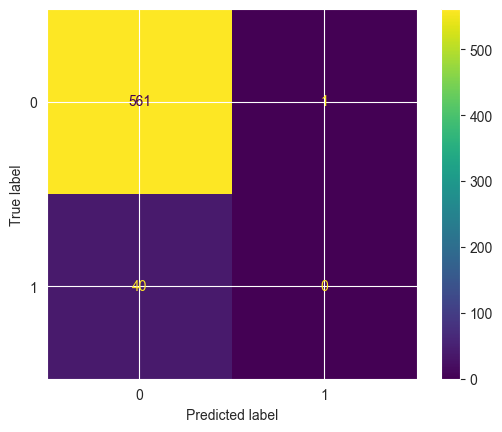

In [243]:
cm_S = confusion_matrix(data_in_location['test']['t'], pre)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_S)
disp.plot()
plt.show()

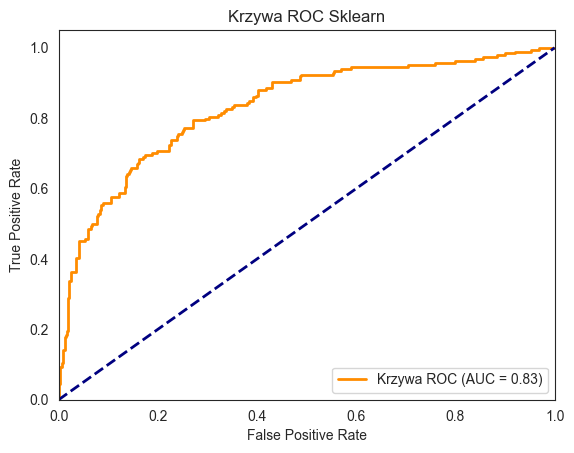

In [ ]:
skl_prob = clf.decision_function(rain_data_by_locations[best_location]['test']['x'])
fpr, tpr, thresholds = roc_curve(rain_data_by_locations[best_location]['test']['t'], skl_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()

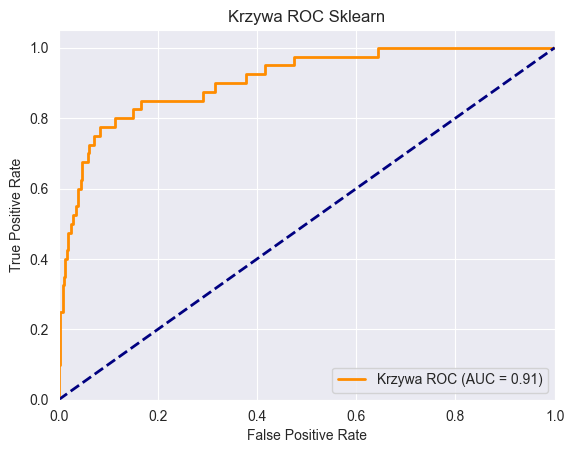

In [252]:
fpr, tpr, thresholds = roc_curve(data_in_location['test']['t'], cum.cus_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC Sklearn')
plt.legend(loc="lower right")
plt.show()